In [1]:
library(did)
library(counties)
library(ggplot2)
library(dplyr)
library(MASS)
library(stringr)
library(foreach)
library(doParallel)
library(LaplacesDemon)
library(glmnet)
library(MASS)
library(reshape)
options(stringsAsFactors=F)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: iterators

Loading required package: parallel

Loading required package: Matrix

Loaded glmnet 3.0-2



Attaching package: ‘reshape’


The following object is masked from ‘package:Matrix’:

    expand


The following object is masked from ‘package:dplyr’:

    rename




In [2]:
variableExpander <- function(keysAndVariable, unitKey, timeKey){ ### Expands into unit/time format
  
  orderedData <- keysAndVariable %>% arrange(get(unitKey), get(timeKey))
  
  outcomeName <- names(keysAndVariable)[!(names(keysAndVariable) %in% c(unitKey, timeKey))]
  
  outcomeMatrixForm <- matrix(NA, nrow=length(unique(keysAndVariable[, unitKey])), 
                              ncol=length(unique(keysAndVariable[, timeKey])), byrow=T)
  
  rownames(outcomeMatrixForm) <- unique(keysAndVariable[, unitKey])
  
  colnames(outcomeMatrixForm) <- str_replace_all(unique(keysAndVariable[, timeKey])[order(unique(keysAndVariable[, timeKey]))], pattern="-", replace="")
  
  for (index in 1:length(keysAndVariable[, unitKey])){
    
    outcomeMatrixForm[keysAndVariable[, unitKey][index], str_replace_all(keysAndVariable[, timeKey][index], pattern="-", replace="")] <- keysAndVariable[, outcomeName][index]
    
  }
  
  return(outcomeMatrixForm)
  
}

In [3]:
desired_clusters <- 30

max_available_clusters <- detectCores()

cl <- makeCluster(min(c(max_available_clusters, desired_clusters))-3)

registerDoParallel(cl)

In [4]:
source('../../causal_inference_methods_code_corrupted.R')

In [5]:
mpdta  <- mpdta %>% mutate(treat= as.numeric(year >= first.treat & first.treat != 0))
write.csv(mpdta, "teenEmployment.csv")

In [6]:
list.files()

[1] "County Data Books 2000"              
[2] "county-ests-employment-and-wages.csv"
[3] "state and county fips.csv"           
[4] "Teen Employment Analysis.ipynb"      
[5] "teenEmployment.csv"

In [7]:
stateAndFips <- read.csv('state and county fips.csv', stringsAsFactors=FALSE)

teenEmploymentData <- read.csv("teenEmployment.csv")
teenEmploymentData$countyreal <- as.character(teenEmploymentData$countyreal)

names(stateAndFips ) <- tolower(names(stateAndFips ))

stateAndFips$fips <- as.character(stateAndFips$fips)


In [8]:
stateRegionData <- cbind.data.frame(as.character(state.abb), as.character(state.region))

names(stateRegionData) <- c('state', 'region')

stateAndFips <- stateAndFips %>% inner_join(stateRegionData)

Joining, by = "state"



In [9]:
teenEmploymentData <- teenEmploymentData %>% group_by(countyreal) %>% mutate(time_since_adoption = cumsum(treat))

In [10]:
censusData<- (stateAndFips %>% inner_join(demographics, by=c("fips"="county_fips")) 
%>% inner_join(life, by=c("fips"="county_fips", "year")) %>% inner_join(income, by=c("fips"="county_fips", "year")))

aggByState <- censusData %>% group_by(state, year) %>% dplyr::summarize(ave_life_expect=mean(income_hh
                                                                                              ))


In [11]:
everythingWithState <- censusData %>% inner_join(teenEmploymentData, by=c("fips"="countyreal", "year"))

In [12]:
names(everythingWithState)

[1] "fips"                "name"                "state"              
 [4] "region"              "year"                "population"         
 [7] "asian"               "black"               "hispanic"           
[10] "white"               "life_expect"         "income_hh"          
[13] "X"                   "lpop"                "lemp"               
[16] "first.treat"         "treat"               "time_since_adoption"

In [13]:
aggByState <- (everythingWithState %>% group_by(state, year) %>% dplyr::summarize(ave_emp=median(lemp))
               %>% arrange(desc(ave_emp)))

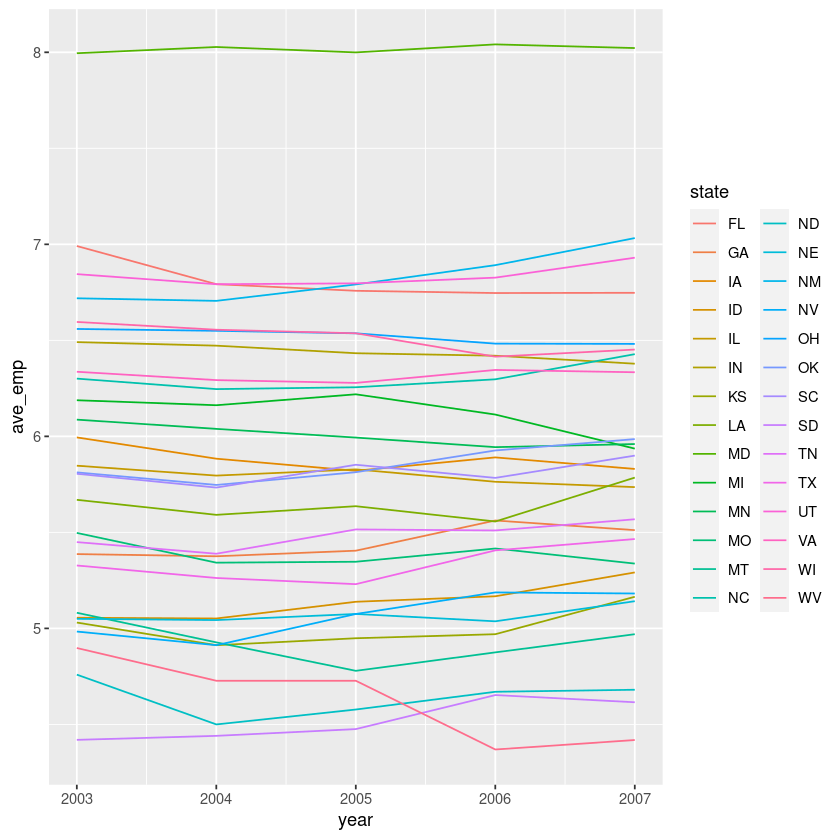

In [14]:


ggplot(aggByState, aes(x=year, y=ave_emp, col=state)) + geom_line()

In [15]:
scoreModel <- glm(treat ~ white+population+income_hh+region, 
                  data=everythingWithState, family=binomial())

In [16]:
summary(scoreModel)


Call:
glm(formula = treat ~ white + population + income_hh + region, 
    family = binomial(), data = everythingWithState)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2042  -0.5768  -0.3746  -0.2779   2.6969  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.040e+00  5.790e-01  -6.977 3.03e-12 ***
white        8.414e-01  5.978e-01   1.407   0.1593    
population   4.173e-07  4.074e-07   1.024   0.3056    
income_hh    4.118e-05  6.090e-06   6.762 1.36e-11 ***
regionSouth -1.136e+00  1.853e-01  -6.131 8.72e-10 ***
regionWest  -7.368e-01  2.961e-01  -2.488   0.0128 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1744.2  on 2444  degrees of freedom
Residual deviance: 1605.0  on 2439  degrees of freedom
AIC: 1617

Number of Fisher Scoring iterations: 5


In [17]:
everythingWithState$probAdopt <- scoreModel$fitted.values

In [18]:
Y = variableExpander(everythingWithState[,c("lemp", 'fips', 'year')], unitKey="fips", timeKey='year')
W = variableExpander(everythingWithState[,c("treat", 'fips', 'year')], unitKey="fips", timeKey='year')
propScoreMatrix = variableExpander(everythingWithState[,c("year", 'fips', 'probAdopt')], unitKey="fips", timeKey='year')

weightMatrix <- propensity.score.to.weight(propScoreMatrix, W)

In [19]:
lemp_MCNNMEstimate <- matrix_completion_causal(Y=Y, W=W, num_iter=1000, K=4, 
                                        lambda_grid=c(10^seq(-4,2,1), seq(2,5,1)),
                                        tolerance=1e-04)
        
lemp_weightedSoftImputeEstimate <- weightedSoftImpute_validate_lambda(Y=Y, W=W, 
                                                                     weight_matrix=weightMatrix, num_iter=1000, K=5, 
                                                             lambda_grid=seq(0, 2000, 100), tolerance=1e-03)
        
lemp_factorModelEstimate <- completion_factor_model(Y=Y, W=W, propScoreMat = propScoreMatrix ,
                                                   numFactors=rankMatrix(lemp_MCNNMEstimate$L_hat)[1])



lemp_r1CompEstimate <- completion_with_rank_estimation_validate_mu(Y=Y, W=W,  
                                                           weight_matrix = weightMatrix,
                                                           initial_rank=40,
                                                           tolerance=1e-04, 
                                                           validation_max_iter=5000,
                                                           min_iter=100,
                                                           max_iter=10000,
                                                           mu_grid=0,
                                                           K=5)

In [20]:
mean(treat.estimator(Y,lemp_MCNNMEstimate$L_hat, W ))

mean(treat.estimator(Y,lemp_weightedSoftImputeEstimate$L_hat, W ))

mean(treat.estimator(Y,lemp_factorModelEstimate, W ))

mean(treat.estimator(Y,lemp_r1CompEstimate$L_hat, W ))

[1] 0.7979719

[1] 3.649805

[1] 1.377489

[1] -0.2079623

In [21]:
meltedUntreatedPotentialOutcomeData <- melt(lemp_r1CompEstimate$L_hat)
names(meltedUntreatedPotentialOutcomeData ) <- c("fips", 'year', 'lemp_untreated')

meltedUntreatedPotentialOutcomeData$fips <- as.character(meltedUntreatedPotentialOutcomeData$fips)

In [22]:
everythingWithState <- everythingWithState %>% inner_join(meltedUntreatedPotentialOutcomeData)

Joining, by = c("fips", "year")



In [23]:
effectAndIncome <- everythingWithState %>% filter(time_since_adoption >= 1) %>% group_by(state, time_since_adoption) %>% summarize(mean_effect=mean(lemp-lemp_untreated, na.rm=T),
                                                                                                               mean_income=mean(life_expect))

In [26]:
exp(.5)

[1] 1.648721

# Evaluating One Step Ahead Predictions


In [27]:
valYearStart = 2006

relevantLempWide <- Y

validationData <- relevantLempWide[, as.numeric(dimnames(relevantLempWide)[[2]]) %in% valYearStart:2007]

meltedValidationData <- melt(validationData)

names(meltedValidationData) <- c("fips", "year", "truth")

savedPredictions <- array(0, dim=c(dim(validationData), 4), dimnames=c(dimnames(validationData), list(c("MC-NNM", "weightedSoftImpute", "FACTOR", "ourMethod"))))


for (fips in dimnames(Y)[[1]]){
    ### Remember, this is not comparable to the SDID results because you had
    ### to drop 1970-1974
    
    for (year in valYearStart:2007){
        
        lempDataNow <- Y[, as.numeric(dimnames(Y)[[2]]) %in% 2003:(year)]
        
        theProbsEstNow <- propScoreMatrix[, as.numeric(dimnames(propScoreMatrix)[[2]]) %in% 2003:(year)]
        
        WThisCountyAndYear <- array(0, dim=dim(lempDataNow),
                                  dimnames=dimnames(lempDataNow))
        
        WThisCountyAndYear[fips, as.character(year)] <- 1
        
        probsThisTime <- WThisCountyAndYear*(1-theProbsEstNow)+theProbsEstNow
        
        weightsThisTime <- propensity.score.to.weight(probsThisTime, WThisCountyAndYear)
        
        mc_nnm_info <- matrix_completion_causal(Y=lempDataNow, W=WThisCountyAndYear, num_iter=1000, K=4, 
                                        lambda_grid=c(10^seq(-4,2,1), seq(2,5,1)),
                                        tolerance=1e-04)
        
        weightedSoftImputeInfo <- weightedSoftImpute_validate_lambda(Y=lempDataNow, W=WThisCountyAndYear, 
                                                                     weight_matrix=weightsThisTime, num_iter=1000, K=5, 
                                                             lambda_grid=seq(0, 2000, 
                                                                             10), tolerance=1e-03)
        
        L_completionFactorModel <- completion_factor_model(Y=lempDataNow, W=WThisCountyAndYear, propScoreMat = probsThisTime,
                                                   numFactors=rankMatrix(mc_nnm_info$L_hat)[1])
        
        weightedr1CompInfo <- completion_with_rank_estimation_validate_mu(
                                  Y=lempDataNow, W=WThisCountyAndYear , weight_matrix=weightsThisTime,
                                  initial_rank=40,
                                  tolerance=1e-04, 
                                  validation_max_iter=5000,
                                  min_iter=100,
                                  max_iter=10000,
                                  mu_grid=0,
                                  K=5)
        
        dimnames(mc_nnm_info$L_hat) <- dimnames(weightedr1CompInfo$L_hat)
        dimnames(weightedSoftImputeInfo$L_hat) <- dimnames(weightedr1CompInfo$L_hat)
        dimnames(L_completionFactorModel) <- dimnames(weightedr1CompInfo$L_hat)
        
        savedPredictions[fips, as.character(year),] <- c(mc_nnm_info$L_hat[fips, as.character(year)], weightedSoftImputeInfo$L_hat[fips, as.character(year)], 
                                                          L_completionFactorModel[fips, as.character(year)], weightedr1CompInfo$L_hat[fips, as.character(year)])
        
    }
    
    
}

In [ ]:

mses <- apply(savedPredictions, MARGIN=3, FUN=function(x) mean((x-validationData)^2))


In [142]:
bootEsts <- bootstrapCI(Y=Y, W=W, weightMatrix= weightMatrix,bootstrap_samps=300, 
                        method=completion_with_rank_estimation_validate_mu,
            initial_rank=40,
                                                           tolerance=1e-04, 
                                                           validation_max_iter=5000,
                                                           min_iter=100,
                                                           max_iter=10000,
                                                           mu_grid=0,
                                                           K=5)

In [156]:
averageEmploymentChanges <- rowMeans(bootEsts)

In [158]:
quantile(averageEmploymentChanges, .025)

2.5% 
-0.3915109

In [159]:
quantile(averageEmploymentChanges, .975)

97.5% 
-0.006889272

In [160]:
mean(averageEmploymentChanges)

[1] -0.1951929

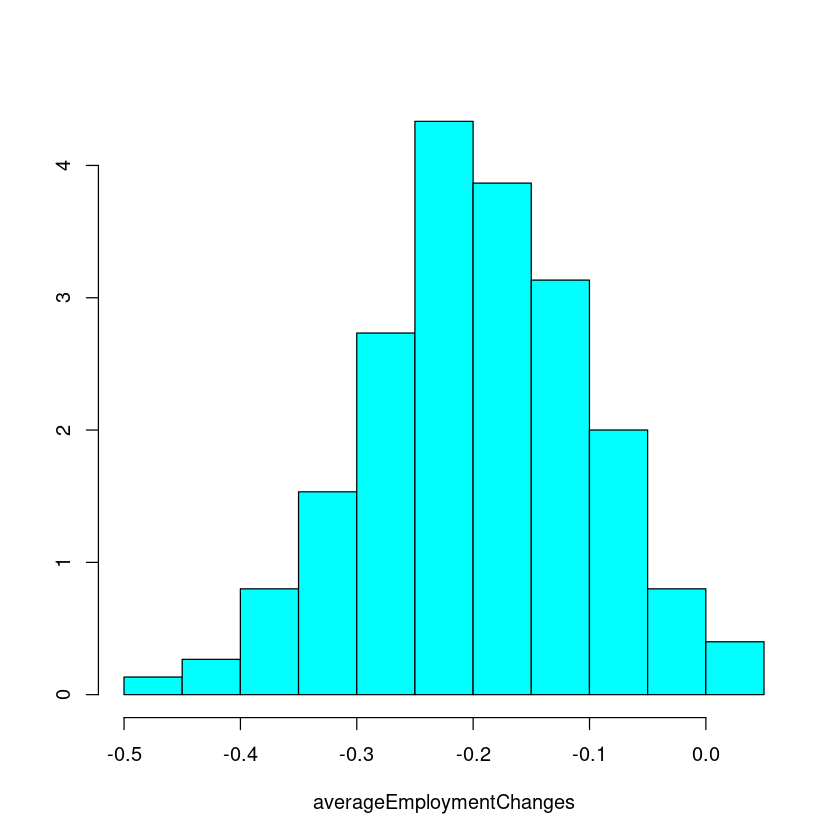

In [161]:
truehist(averageEmploymentChanges)

In [165]:
colMeans(bootEsts)

bootEstData <- cbind.data.frame(2004:2007, colMeans(bootEsts))
colnames(bootEstData) <- c("Year", "Value")

[1]  0.03115448 -0.01589523 -0.46254735 -0.33348362

In [174]:
Cis_r1comp <- apply(bootEsts, MARGIN=2, 
                                FUN=bs_percentile_method ,.95)


names(Cis_r1comp) <- 2004:2007


ciExample <- cbind.data.frame(2004:2007, t(Cis_r1comp ))
names(ciExample) <- c("Year", "Lower", "Upper")
                    
ciExamplePlot <- ggplot(ciExample, aes(x=factor(Year), y = Upper, group=1)) +
  geom_line(aes(y = Lower), linetype='dashed') + 
  geom_line(aes(y = Upper), linetype='dashed') + 
  geom_line(data=bootEstData, aes(x=factor(Year), y=Value), color='black', lwd=2)+
  geom_ribbon(aes(ymin = Lower, ymax = Upper), fill = "blue", alpha = .5) + 
  theme_bw(base_size=20)+ xlab("Year") + ylab("Difference in Cigarette Sales (per Capita)") + 
  ggtitle("Estimated Effect of\n Minimum Wage Law Passage,\nwith 95% Bootstrapped Confidence Inervals")

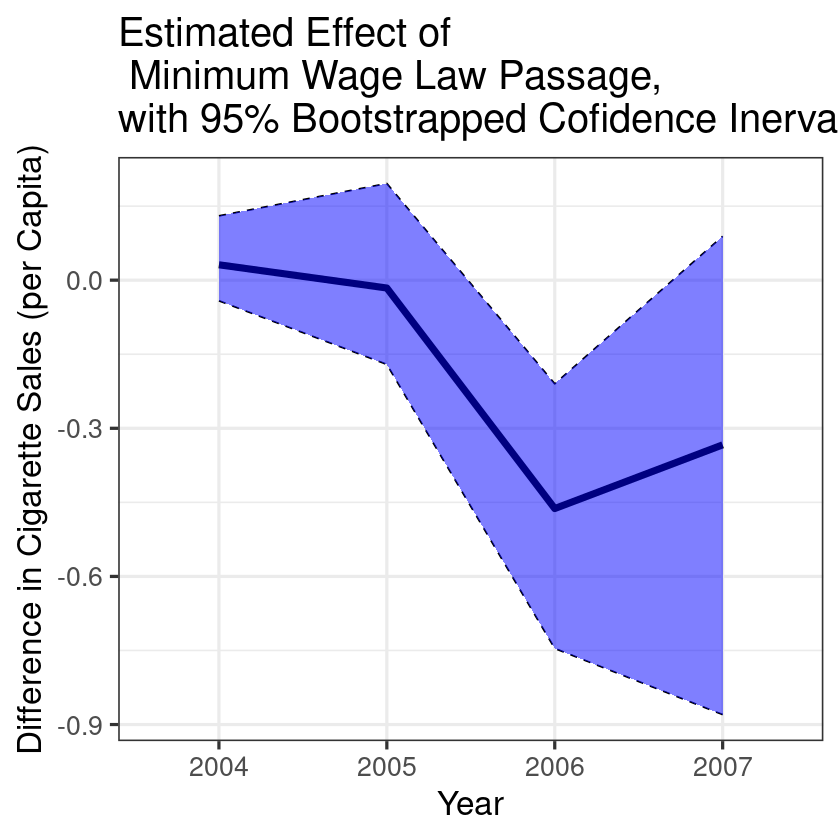

In [175]:
ciExamplePlot

In [168]:
meanChanges = rowMeans(bootEsts)

In [170]:
mean(meanChanges)

[1] -0.1951929

In [171]:
quantile(meanChanges, c(.025, .975))

2.5%        97.5% 
-0.391510939 -0.006889272